In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
class MNIST_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(784,128)
    self.l2 = nn.Linear(128,64)
    self.l3 = nn.Linear(64,10)

  def forward(self, x):
    h1 = nn.functional.relu(self.l1(x))
    h2 = nn.functional.relu(self.l2(h1))
    output = nn.LogSoftmax(dim=1)(self.l3(h2))  
    return output

model = MNIST_classifier()
print(model)

MNIST_classifier(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
! pip install pytorch_lightning

     |████████████████████████████████| 552kB 24.0MB/s 
     |████████████████████████████████| 276kB 55.0MB/s 
     |████████████████████████████████| 92kB 13.0MB/s 
     |████████████████████████████████| 829kB 21.0MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=20f766612e1432925817a44cb3a226c45846e78e1612fae339751fffdd7964ab
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=88b6b23c0e8e0c81659f260f487bde790be3d0a33f399b5580c946fe55ab21f4
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully unin

In [ ]:
criterion = nn.NLLLoss()

### Lightning Magic
1. Model
2. Optmizer
3. Data
4. Training loop
5. Validation loop

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from torch.utils.data import random_split
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor
from torch import nn, optim

class light_MNIST_classifier(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(784,128)
    self.l2 = nn.Linear(128,64)
    self.l3 = nn.Linear(64,10)
    self.criterion = nn.NLLLoss()
    self.transform = Compose([ToTensor(),])

  def forward(self, x):
    h1 = nn.functional.relu(self.l1(x))
    h2 = nn.functional.relu(self.l2(h1))
    output = nn.LogSoftmax(dim=1)(self.l3(h2))  
    return output

  def configure_optimizers(self):
    optimizer = optim.SGD(self.parameters(), lr=0.003, momentum=0.9)
    return optimizer

  def training_step(self,batch, batch_idx):
    images,labels = batch
    images = images.view(images.shape[0], -1)
    output = self(images)
    loss = self.criterion(output, labels)

    acc = accuracy(output, labels)
    prog_bar = {'train_acc': acc}
    return {'loss': loss,'progress_bar':prog_bar}
    #return loss

  def validation_step(self,batch, batch_idx):
    results = self.training_step(batch, batch_idx)
    results['progress_bar']['val_acc'] = results['progress_var']['train_acc']
    del results['progress_var']['train_acc']
    return results

  
  def validation_epoch_end(self, val_step_outputs):
    #[result1, result2, result3]
    avg_validation_loss = torch.tensor([x['loss'] for x in val_step_outputs]).mean()
    avg_validation_acc = torch.tensor([x['progress_bar']['val_acc'] for x in val_step_outputs]).mean()

    progress_bar1 = {'avg_val': avg_validation_acc}
    return {'val_loss':avg_validation_loss, 'progress_bar':pbar}

  def prepare_data(self):
     # only happens at only one CPU
     datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform = self.transform)

  # def setup(self,step):
  #   dataset= datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform = self.transform)
  #   self.train,self.val = random_split(dataset,[55000,5000])

  def train_dataloader(self):
    dataset= datasets.MNIST('PATH_TO_STORE_TRAINSET', download=False, train=True, transform = self.transform)
    self.train,self.val = random_split(dataset,[55000,5000])
    train_loader = torch.utils.data.DataLoader(self.train, batch_size=64, shuffle=True)
    return train_loader

  # def val_dataloader(self):
  #   val_loader = torch.utils.data.DataLoader(self.val, batch_size=64, shuffle=False)
  #   return val_loader

model = light_MNIST_classifier()

In [ ]:
trainer = pl.Trainer(max_epochs = 3, gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | l1        | Linear  | 100 K 
1 | l2        | Linear  | 8 K   
2 | l3        | Linear  | 650   
3 | criterion | NLLLoss | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 1


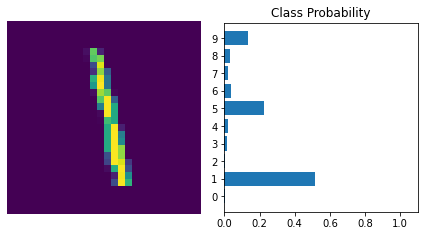

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.6867


In [ ]:
torch.save(model, './my_mnist_model.pt') 